# Google Mobility India data exploration

### Notes on the data:
**Google mobility data:** (https://www.google.com/covid19/mobility/data_documentation.html?hl=en)

* Changes for each day are compared to a baseline value for that day of the week (where the baseline is the median value, for the corresponding day of the week, during the 5-week period Jan 3–Feb 6, 2020)
* Insights calculated based on data from users who have opted-in to Location History for their Google Account, so the data represents a sample of Google users.

This link is also useful https://support.google.com/covid19-mobility/answer/9825414?hl=en

**COVID19-India api data:** (https://api.covid19india.org/csv/)

Using the `state_wise_daily.csv` dataset

In [98]:
from pathlib import Path
from typing import Dict, Optional, Sequence, Tuple

import numpy as np
import pandas as pd

from adaptive.etl.covid19india import download_data, load_statewise_data, get_time_series, get_google_mobility
from adaptive.utils import cwd, days

ImportError: cannot import name 'get_google_mobility' from 'adaptive.etl.covid19india' (/Users/caitlinloftus/Projects/adaptive-lockdown/adaptive/etl/covid19india.py)

In [2]:
root = Path('/Users/caitlinloftus/Projects/adaptive-lockdown/studies/india_districts/')
data = root/"data"

download_data(data, "Global_Mobility_Report.csv", base_url = "https://www.gstatic.com/covid19/mobility/")
download_data(data, "state_wise_daily.csv")

In [3]:
state_df = load_statewise_data(data/"state_wise_daily.csv")
state_level_time_series = get_time_series(state_df, 'state')

In [4]:
google_mobility_india = get_google_mobility_india(data/"Global_Mobility_Report.csv", "IN")

/Users/caitlinloftus/Projects/adaptive-lockdown/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/caitlinloftus/Projects/adaptive-lockdown/adaptive/etl/covid19india.py:358: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  india_df["sub_region_1"] = india_df["sub_region_1"].str.replace(" and ", " & ")


In [5]:
google_mobility_india['sub_region_1'].fillna('India', inplace=True)

In [6]:
google_mobility_india = google_mobility_india.rename(columns={'sub_region_1':'state'}).set_index(['state','date'])
state_level_time_series.rename_axis(['state','date'], axis=0, inplace=True)

## General trends for India 

### 1. Mobility data

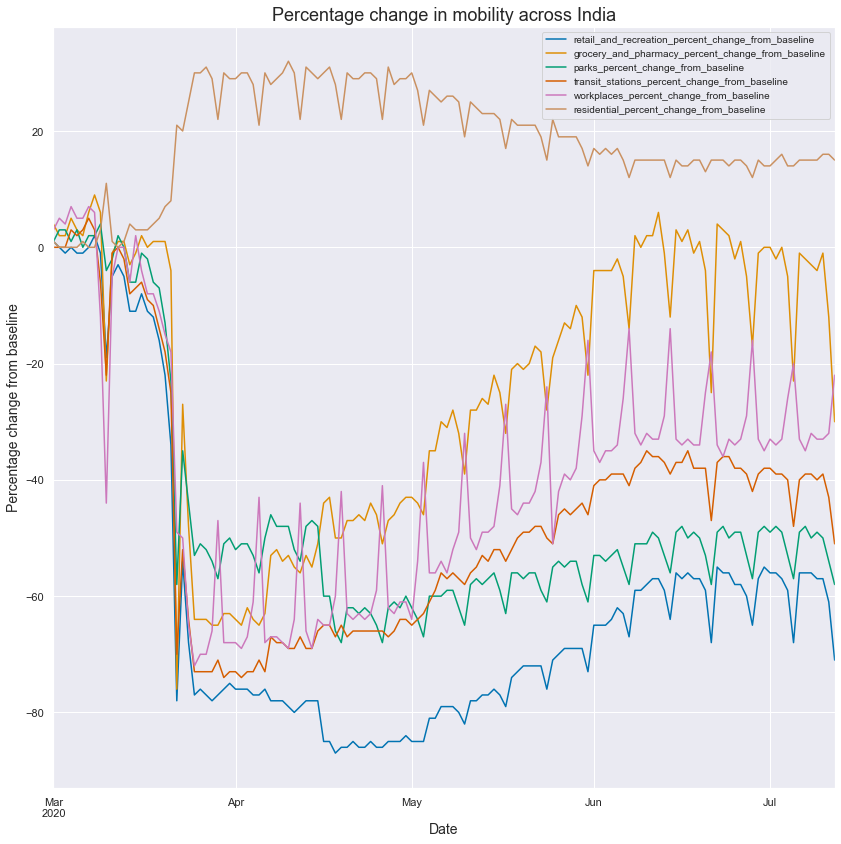

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_palette("colorblind")

fig, ax = plt.subplots(figsize=(14,14))
f = google_mobility_india.loc['India'].loc['2020-03-01':].plot(ax=ax)

plt.legend(loc='upper right', prop={'size': 10})
f.set_xlabel("Date", fontsize=14)
f.set_ylabel("Percentage change from baseline", fontsize=14)
f.set_title("Percentage change in mobility across India", fontsize=18)

plt.savefig('./google_mobility_india.png')

### 2. COVID data

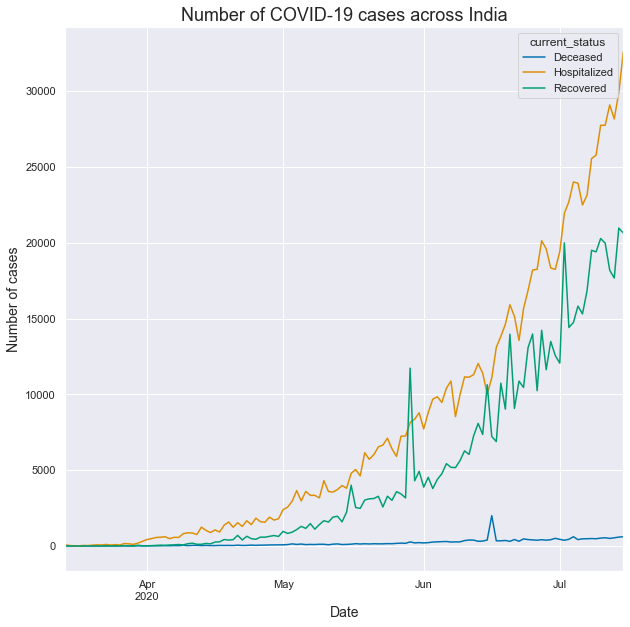

In [51]:
fig, ax = plt.subplots(figsize=(10,10))
f = state_level_time_series.loc['India'].iloc[:,:3].plot(ax=ax)

f.set_xlabel("Date", fontsize=14)
f.set_ylabel("Number of cases", fontsize=14)
f.set_title("Number of COVID-19 cases across India", fontsize=18)
plt.savefig('./india_covid_cases.png')

## Mobility and COVID

In [9]:
joined_df = state_level_time_series.iloc[:,:3].join(google_mobility_india, how='outer')

### Add time lagged columns
Shift mobility columns by 7 and 14 days 

In [10]:
def add_lag_col(grp):
    for lag in [7, 14]:
        for col in ['retail_and_recreation_percent_change_from_baseline', 'grocery_and_pharmacy_percent_change_from_baseline', 'parks_percent_change_from_baseline', 'transit_stations_percent_change_from_baseline', 'workplaces_percent_change_from_baseline', 'residential_percent_change_from_baseline']:
            grp[col + '_lag_' + str(lag)] = grp[col].shift(-lag)
    return grp

In [11]:
full_df = joined_df.groupby(level=0).apply(add_lag_col)

### Country level correlations

In [28]:
full_df.loc['India'].corr()

,Deceased,Hospitalized,Recovered,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,retail_and_recreation_percent_change_from_baseline_lag_7,...,parks_percent_change_from_baseline_lag_7,transit_stations_percent_change_from_baseline_lag_7,workplaces_percent_change_from_baseline_lag_7,residential_percent_change_from_baseline_lag_7,retail_and_recreation_percent_change_from_baseline_lag_14,grocery_and_pharmacy_percent_change_from_baseline_lag_14,parks_percent_change_from_baseline_lag_14,transit_stations_percent_change_from_baseline_lag_14,workplaces_percent_change_from_baseline_lag_14,residential_percent_change_from_baseline_lag_14
Deceased,1.000000,0.733522,0.715352,0.206124,0.564962,-0.068053,0.385820,0.391647,-0.416602,0.582445,...,0.227746,0.615831,0.528151,-0.588386,0.614479,0.555837,0.349881,0.567379,0.491361,-0.571735
Hospitalized,0.733522,1.000000,0.979015,0.242492,0.635998,-0.090025,0.439961,0.493670,-0.496444,0.710486,...,0.241586,0.751820,0.721318,-0.758925,0.818803,0.750489,0.417440,0.779339,0.736088,-0.794907
Recovered,0.715352,0.979015,1.000000,0.270361,0.619087,-0.043298,0.435955,0.469072,-0.486082,0.695499,...,0.274828,0.696842,0.654122,-0.705441,0.775074,0.682118,0.429315,0.702241,0.651906,-0.717694
retail_and_recreation_percent_change_from_baseline,0.206124,0.242492,0.270361,1.000000,0.700415,0.975728,0.963338,0.881704,-0.933574,0.901759,...,0.912648,0.790946,0.694242,-0.774983,0.748024,0.161171,0.807609,0.534633,0.440214,-0.538892
grocery_and_pharmacy_percent_change_from_baseline,0.564962,0.635998,0.619087,0.700415,1.000000,0.553824,0.845081,0.803916,-0.825685,0.679473,...,0.546502,0.742373,0.681878,-0.747090,0.652527,0.556762,0.547216,0.604188,0.550284,-0.643657
parks_percent_change_from_baseline,-0.068053,-0.090025,-0.043298,0.975728,0.553824,1.000000,0.893653,0.782529,-0.845409,0.859531,...,0.914326,0.714190,0.592750,-0.676908,0.691627,0.040358,0.792755,0.454392,0.334369,-0.432650
transit_stations_percent_change_from_baseline,0.385820,0.439961,0.435955,0.963338,0.845081,0.893653,1.000000,0.943043,-0.973518,0.897048,...,0.853204,0.853209,0.778738,-0.848037,0.780823,0.332300,0.778850,0.624064,0.553704,-0.648446
workplaces_percent_change_from_baseline,0.391647,0.493670,0.469072,0.881704,0.803916,0.782529,0.943043,1.000000,-0.981449,0.820569,...,0.750627,0.800138,0.822074,-0.854356,0.737943,0.327927,0.704733,0.610671,0.642952,-0.695781
residential_percent_change_from_baseline,-0.416602,-0.496444,-0.486082,-0.933574,-0.825685,-0.845409,-0.973518,-0.981449,1.000000,-0.862836,...,-0.806703,-0.817647,-0.803216,0.859230,-0.750915,-0.298157,-0.738248,-0.594328,-0.584791,0.663091
retail_and_recreation_percent_change_from_baseline_lag_7,0.582445,0.710486,0.695499,0.901759,0.679473,0.859531,0.897048,0.820569,-0.862836,1.000000,...,0.971197,0.957103,0.868883,-0.925077,0.881463,0.426522,0.895228,0.747797,0.637797,-0.731234


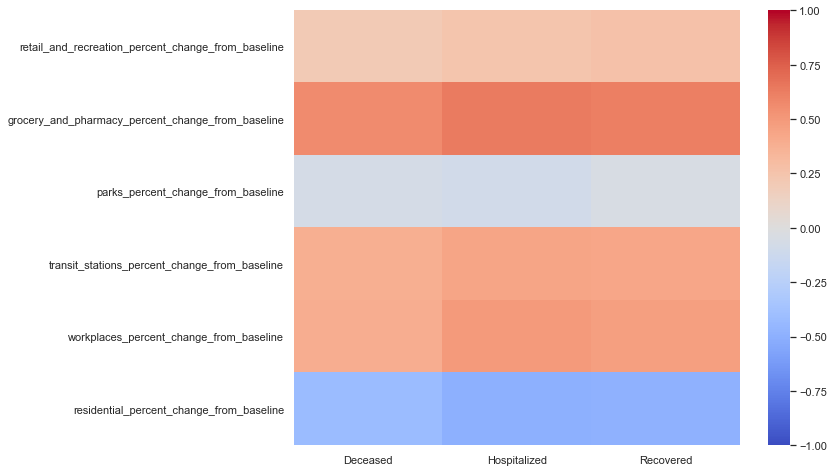

In [66]:
fig, ax = plt.subplots(figsize=(10,8))

sns.heatmap(full_df.loc['India'][['Deceased', 'Hospitalized', 'Recovered', 'retail_and_recreation_percent_change_from_baseline',
                      'grocery_and_pharmacy_percent_change_from_baseline', 
                      'parks_percent_change_from_baseline', 'transit_stations_percent_change_from_baseline',
                      'workplaces_percent_change_from_baseline', 'residential_percent_change_from_baseline']].corr().loc['retail_and_recreation_percent_change_from_baseline':, :'Recovered'],
            cmap='coolwarm', ax=ax, vmin=-1, vmax=1)

### State level correlations

In [24]:
full_df.groupby(level=0).apply(lambda x: x[['Hospitalized','retail_and_recreation_percent_change_from_baseline',
                                            'retail_and_recreation_percent_change_from_baseline_lag_7',
                                            'retail_and_recreation_percent_change_from_baseline_lag_14']].corr().loc['Hospitalized'])

Hospitalized,Hospitalized,retail_and_recreation_percent_change_from_baseline,retail_and_recreation_percent_change_from_baseline_lag_7,retail_and_recreation_percent_change_from_baseline_lag_14
state,,,,
Andaman & Nicobar Islands,1.0,0.247569,0.415077,0.212103
Andhra Pradesh,1.0,0.200654,0.530730,0.581856
Arunachal Pradesh,1.0,0.010189,0.070219,0.302398
Assam,1.0,-0.048508,0.162949,0.424364
Bihar,1.0,0.214476,0.597035,0.780359
Chandigarh,1.0,0.043886,0.210529,0.308369
Chhattisgarh,1.0,0.264974,0.630079,0.648099
Dadra & Nagar Haveli,1.0,0.062743,0.239513,0.285974
Daman & Diu,NaN,NaN,NaN,NaN


In [76]:
india = full_df.loc['India']

In [17]:
maharashtra_normalized = (maharashtra-maharashtra.mean())/maharashtra.std()

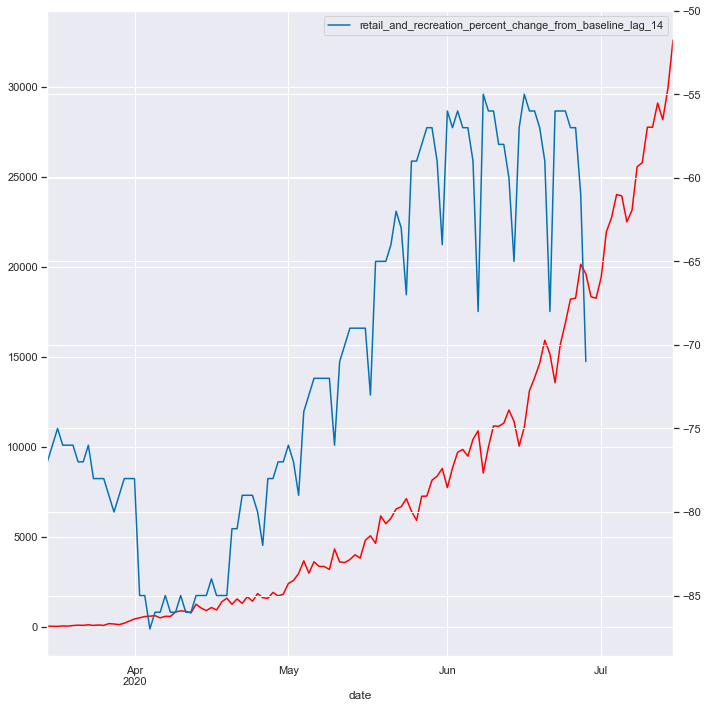

In [94]:
fig, ax1 = plt.subplots(figsize=(10,10))

india['Hospitalized'].plot(ax=ax1, color='Red')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

india.loc['2020-03-15':][['retail_and_recreation_percent_change_from_baseline_lag_14']].plot(ax=ax2)
plt.ylim(top=-50)
fig.tight_layout()  # otherwise the right y-label is slightly clipped


In [215]:
full_df['date'] = full_df.index.get_level_values(level=1)
full_df['week'] = full_df['date'].dt.week

In [207]:
total_cases = pd.DataFrame(joined_df.groupby(level=0).apply(lambda x: x['Hospitalized'].sum()))
total_cases = total_cases.reset_index().rename(columns={0:'count'})
states_cases_above_1000 = total_cases['state'][total_cases['count'] > 1000]

In [210]:
df_over_1000_cases = full_df.loc[states_cases_above_1000]

In [216]:
states_weekly = full_df.groupby(['state','week']).sum()

## USA
### Country level

In [144]:
us_overall = pd.read_csv('https://covidtracking.com/api/v1/us/daily.csv',
                         parse_dates=['date'],
                        index_col=['date']).sort_index()

In [192]:
us_overall_cases = us_overall[['deathIncrease', 'positiveIncrease']]

In [99]:
def get_google_mobility(mobility_data_path: Path, country_code: str):
    full_df = pd.read_csv(mobility_data_path, parse_dates = ["date"])
    country_df = full_df[full_df["country_region_code"] == country_code]
    country_df["sub_region_1"] = country_df["sub_region_1"].str.replace(" and ", " & ")
    return country_df[google_mobility_columns]

### State level

In [128]:
url = 'https://covidtracking.com/api/v1/states/daily.csv'
states = pd.read_csv(url,
                     parse_dates=['date'],
                     index_col=['state', 'date']).sort_index()

states_meta = pd.read_csv('https://covidtracking.com/api/v1/states/info.csv')
state_name_lookup = states_meta[['state', 'name']]

In [130]:
states = states.reset_index().merge(state_name_lookup, on='state').set_index(['name', 'date']).sort_index()

In [190]:
us_state_cases = states[['recovered', 'death', 'positive']]

In [101]:
google_mobility_columns = [
    "sub_region_1",
    "date",
    "retail_and_recreation_percent_change_from_baseline",
    "grocery_and_pharmacy_percent_change_from_baseline",
    "parks_percent_change_from_baseline",
    "transit_stations_percent_change_from_baseline",
    "workplaces_percent_change_from_baseline",
    "residential_percent_change_from_baseline"
 ]

In [102]:
us_mobility = get_google_mobility("./data/Global_Mobility_Report.csv", "US")

/Users/caitlinloftus/Projects/adaptive-lockdown/venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [104]:
us_mobility['sub_region_1'].fillna('US', inplace=True)

In [105]:
us_mobility = us_mobility.rename(columns={'sub_region_1':'state'}).set_index(['state','date'])

In [106]:
us_mobility

retail_and_recreation_percent_change_from_baseline  \
state   date                                                             
US      2020-02-15                                                6.0    
        2020-02-16                                                7.0    
        2020-02-17                                                6.0    
        2020-02-18                                                0.0    
        2020-02-19                                                2.0    
...                                                               ...    
Wyoming 2020-07-06                                                NaN    
        2020-07-07                                                NaN    
        2020-07-08                                                NaN    
        2020-07-09                                                NaN    
        2020-07-10                                                NaN    

                    grocery_and_pharmacy_percent_change_from_baseline  \
state   date                                                            
US      2020-02-15                                                2.0   
        2020-02-16                                                1.0   
        2020-02-17                                                0.0   
        2020-02-18                                               -1.0   
        2020-02-19                                                0.0   
...                                                               ...   
Wyoming 2020-07-06                                                NaN   
        2020-07-07                                                NaN   
        2020-07-08                                                NaN   
        2020-07-09                                                NaN   
        2020-07-10                                                NaN   

                    parks_percent_change_from_baseline  \
state   date                                             
US      2020-02-15                                15.0   
        2020-02-16                                16.0   
        2020-02-17                                28.0   
        2020-02-18                                 6.0   
        2020-02-19                                 8.0   
...                                                ...   
Wyoming 2020-07-06                                 NaN   
        2020-07-07                                 NaN   
        2020-07-08                                 NaN   
        2020-07-09                                 NaN   
        2020-07-10                                 NaN   

                    transit_stations_percent_change_from_baseline  \
state   date                                                        
US      2020-02-15                                            3.0   
        2020-02-16                                            2.0   
        2020-02-17                                           -9.0   
        2020-02-18                                            1.0   
        2020-02-19                                            1.0   
...                                                           ...   
Wyoming 2020-07-06                                            NaN   
        2020-07-07                                            NaN   
        2020-07-08                                            NaN   
        2020-07-09                                            NaN   
        2020-07-10                                            NaN   

                    workplaces_percent_change_from_baseline  \
state   date                                                  
US      2020-02-15                                      2.0   
        2020-02-16                                      0.0   
        2020-02-17                                    -24.0   
        2020-02-18                                      0.0   
        2020-02-19                                      1.0   
...          

In [169]:
us_mobility

retail_and_recreation_percent_change_from_baseline  \
state   date                                                             
US      2020-02-15                                                6.0    
        2020-02-16                                                7.0    
        2020-02-17                                                6.0    
        2020-02-18                                                0.0    
        2020-02-19                                                2.0    
...                                                               ...    
Wyoming 2020-07-06                                                NaN    
        2020-07-07                                                NaN    
        2020-07-08                                                NaN    
        2020-07-09                                                NaN    
        2020-07-10                                                NaN    

                    grocery_and_pharmacy_percent_change_from_baseline  \
state   date                                                            
US      2020-02-15                                                2.0   
        2020-02-16                                                1.0   
        2020-02-17                                                0.0   
        2020-02-18                                               -1.0   
        2020-02-19                                                0.0   
...                                                               ...   
Wyoming 2020-07-06                                                NaN   
        2020-07-07                                                NaN   
        2020-07-08                                                NaN   
        2020-07-09                                                NaN   
        2020-07-10                                                NaN   

                    parks_percent_change_from_baseline  \
state   date                                             
US      2020-02-15                                15.0   
        2020-02-16                                16.0   
        2020-02-17                                28.0   
        2020-02-18                                 6.0   
        2020-02-19                                 8.0   
...                                                ...   
Wyoming 2020-07-06                                 NaN   
        2020-07-07                                 NaN   
        2020-07-08                                 NaN   
        2020-07-09                                 NaN   
        2020-07-10                                 NaN   

                    transit_stations_percent_change_from_baseline  \
state   date                                                        
US      2020-02-15                                            3.0   
        2020-02-16                                            2.0   
        2020-02-17                                           -9.0   
        2020-02-18                                            1.0   
        2020-02-19                                            1.0   
...                                                           ...   
Wyoming 2020-07-06                                            NaN   
        2020-07-07                                            NaN   
        2020-07-08                                            NaN   
        2020-07-09                                            NaN   
        2020-07-10                                            NaN   

                    workplaces_percent_change_from_baseline  \
state   date                                                  
US      2020-02-15                                      2.0   
        2020-02-16                                      0.0   
        2020-02-17                                    -24.0   
        2020-02-18                                      0.0   
        2020-02-19                                      1.0   
...          

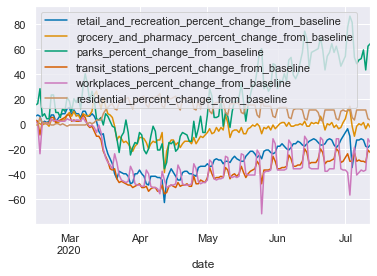

In [183]:
us_mobility.loc['US'].plot()

In [193]:
joined_us = us_overall_cases.join(us_mobility.loc['US'])

In [194]:
for lag in [7, 14]:
    for col in ['retail_and_recreation_percent_change_from_baseline', 'grocery_and_pharmacy_percent_change_from_baseline', 'parks_percent_change_from_baseline', 'transit_stations_percent_change_from_baseline', 'workplaces_percent_change_from_baseline', 'residential_percent_change_from_baseline']:
        joined_us[col + '_lag_' + str(lag)] = joined_us[col].shift(-lag)

In [195]:
joined_us

,deathIncrease,positiveIncrease,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,retail_and_recreation_percent_change_from_baseline_lag_7,grocery_and_pharmacy_percent_change_from_baseline_lag_7,parks_percent_change_from_baseline_lag_7,transit_stations_percent_change_from_baseline_lag_7,workplaces_percent_change_from_baseline_lag_7,residential_percent_change_from_baseline_lag_7,retail_and_recreation_percent_change_from_baseline_lag_14,grocery_and_pharmacy_percent_change_from_baseline_lag_14,parks_percent_change_from_baseline_lag_14,transit_stations_percent_change_from_baseline_lag_14,workplaces_percent_change_from_baseline_lag_14,residential_percent_change_from_baseline_lag_14
date,,,,,,,,,,,,,,,,,,,,
2020-01-22,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-23,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-24,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-25,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-26,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-12,476,60978,-17.0,-3.0,64.0,-23.0,-15.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-13,327,58465,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-14,736,62879,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [196]:
joined_us.corr()

,deathIncrease,positiveIncrease,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,retail_and_recreation_percent_change_from_baseline_lag_7,grocery_and_pharmacy_percent_change_from_baseline_lag_7,parks_percent_change_from_baseline_lag_7,transit_stations_percent_change_from_baseline_lag_7,workplaces_percent_change_from_baseline_lag_7,residential_percent_change_from_baseline_lag_7,retail_and_recreation_percent_change_from_baseline_lag_14,grocery_and_pharmacy_percent_change_from_baseline_lag_14,parks_percent_change_from_baseline_lag_14,transit_stations_percent_change_from_baseline_lag_14,workplaces_percent_change_from_baseline_lag_14,residential_percent_change_from_baseline_lag_14
deathIncrease,1.000000,0.535943,-0.658069,-0.563280,-0.296091,-0.718081,-0.690502,0.709951,-0.504914,-0.396093,-0.118924,-0.595420,-0.597085,0.576128,-0.351701,-0.231321,0.082831,-0.469857,-0.487694,0.435055
positiveIncrease,0.535943,1.000000,-0.434194,-0.333757,0.339748,-0.524729,-0.564554,0.428774,-0.441769,-0.336322,0.301287,-0.539566,-0.571217,0.439932,-0.390212,-0.272319,0.315562,-0.496880,-0.509071,0.391268
retail_and_recreation_percent_change_from_baseline,-0.658069,-0.434194,1.000000,0.804677,0.480326,0.942122,0.780755,-0.817020,0.859573,0.806319,0.374021,0.856093,0.718194,-0.711318,0.605638,0.597957,0.205382,0.655583,0.554671,-0.502511
grocery_and_pharmacy_percent_change_from_baseline,-0.563280,-0.333757,0.804677,1.000000,0.507094,0.734396,0.622742,-0.648237,0.514356,0.619722,0.342352,0.526016,0.459885,-0.428090,0.294870,0.337774,0.200626,0.342167,0.301646,-0.247694
parks_percent_change_from_baseline,-0.296091,0.339748,0.480326,0.507094,1.000000,0.358838,0.222627,-0.418936,0.511759,0.547682,0.862929,0.423506,0.313580,-0.467694,0.483553,0.440697,0.779460,0.446855,0.328255,-0.463972
transit_stations_percent_change_from_baseline,-0.718081,-0.524729,0.942122,0.734396,0.358838,1.000000,0.926850,-0.923314,0.810982,0.764510,0.259134,0.903337,0.851503,-0.808371,0.538014,0.566493,0.094442,0.678362,0.665232,-0.575543
workplaces_percent_change_from_baseline,-0.690502,-0.564554,0.780755,0.622742,0.222627,0.926850,1.000000,-0.953286,0.649152,0.649482,0.182461,0.818502,0.877397,-0.822595,0.401499,0.465897,0.060380,0.615622,0.709751,-0.613864
residential_percent_change_from_baseline,0.709951,0.428774,-0.817020,-0.648237,-0.418936,-0.923314,-0.953286,1.000000,-0.710128,-0.693267,-0.342043,-0.849248,-0.890175,0.896658,-0.469918,-0.507725,-0.194522,-0.661433,-0.734190,0.697293
retail_and_recreation_percent_change_from_baseline_lag_7,-0.504914,-0.441769,0.859573,0.514356,0.511759,0.810982,0.649152,-0.710128,1.000000,0.804677,0.480326,0.942122,0.780755,-0.817020,0.859573,0.806319,0.374021,0.856093,0.718194,-0.711318
grocery_and_pharmacy_percent_change_from_baseline_lag_7,-0.396093,-0.336322,0.806319,0.619722,0.547682,0.764510,0.649482,-0.693267,0.804677,1.000000,0.507094,0.734396,0.622742,-0.648237,0.514356,0.619722,0.342352,0.526016,0.459885,-0.428090


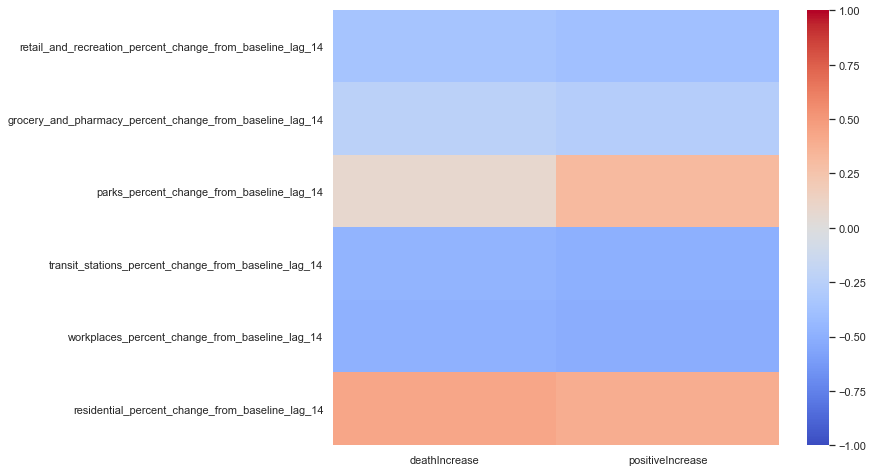

In [199]:
fig, ax = plt.subplots(figsize=(10,8))

sns.heatmap(joined_us[['deathIncrease', 'positiveIncrease', 'retail_and_recreation_percent_change_from_baseline_lag_14',
                      'grocery_and_pharmacy_percent_change_from_baseline_lag_14', 
                      'parks_percent_change_from_baseline_lag_14', 'transit_stations_percent_change_from_baseline_lag_14',
                      'workplaces_percent_change_from_baseline_lag_14', 'residential_percent_change_from_baseline_lag_14']].corr().loc['retail_and_recreation_percent_change_from_baseline_lag_14':, :'positiveIncrease'],
            cmap='coolwarm', ax=ax, vmin=-1, vmax=1)

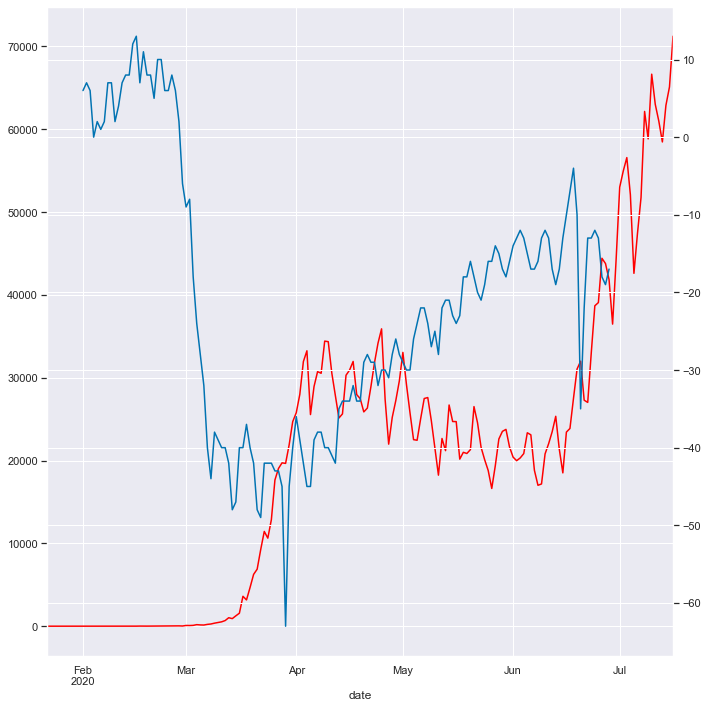

In [203]:
fig, ax1 = plt.subplots(figsize=(10,10))

joined_us['positiveIncrease'].plot(ax=ax1, color='Red')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

joined_us['retail_and_recreation_percent_change_from_baseline_lag_14'].plot(ax=ax2)
fig.tight_layout()  # otherwise the right y-label is slightly clipped


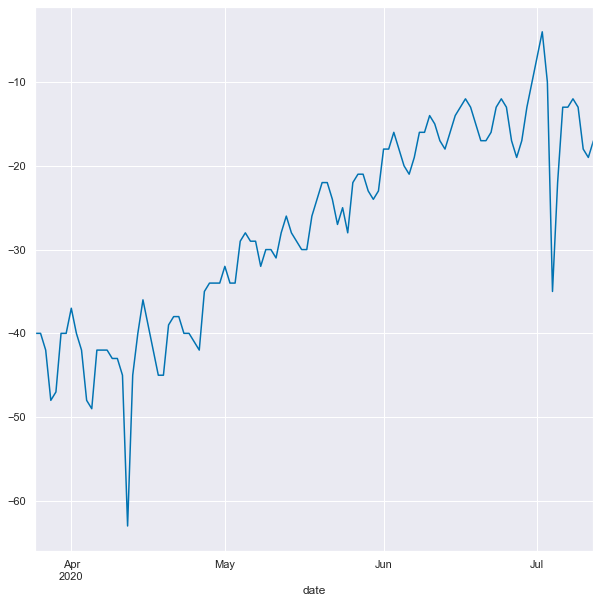

In [188]:
fig, ax1 = plt.subplots(figsize=(10,10))

joined_us['retail_and_recreation_percent_change_from_baseline'].plot(ax=ax1)
plt.show()